# Stroke graph using the `COINS` class

This example illustrates how to use the `COINS` algorithm with the `strokegraph` functions to create a stroke graph. It is a dual graph as defined in *Porta, S., Crucitti, P. and Latora, V., 2006. The network analysis of urban streets: A dual approach. Physica A: Statistical Mechanics and its Applications, 369(2), pp.853-866. [https://doi.org/10.1016/j.physa.2005.12.063](https://doi.org/10.1016/j.physa.2005.12.063)*.

For COINS, refer to *Tripathy, P., Rao, P., Balakrishnan, K., & Malladi, T. 2021. An open-source tool to extract natural continuity and hierarchy of urban street networks. Environment and Planning B: Urban Analytics and City Science, 48(8), 2188-2205. [https://doi.org/10.1177/2399808320967680](https://doi.org/10.1177/2399808320967680)*

For the geometric metrics on the dual graph, refer to *El Gouj, H., Rincón-Acosta, C. and Lagesse, C., 2022. Urban morphogenesis analysis based on geohistorical road data. Applied Network Science, 7(1), p.6 [https://doi.org/10.1007/s41109-021-00440-0](https://doi.org/10.1007/s41109-021-00440-0).*.

In [1]:
import folium
import geopandas as gpd
import momepy
import networkx as nx
from matplotlib import pyplot as plt

We use the Bubenec dataset as an example. The input of `momepy.COINS` needs to be a `geopandas.GeoDataFrame` of `shapely.LineString` object representing edges of a valid `networkx.Graph`.

## Generate strokes and stroke graph

In [2]:
gdf = gpd.read_file(momepy.datasets.get_path("bubenec"), layer="streets")
# gdf = momepy.remove_false_nodes(gdf)
primal_graph = momepy.gdf_to_nx(gdf, preserve_index=True, approach="primal")
points, lines = momepy.nx_to_gdf(primal_graph, points=True, lines=True)

In the primal graph, each street intersection is a node, and each street segment between intersections is an edge:

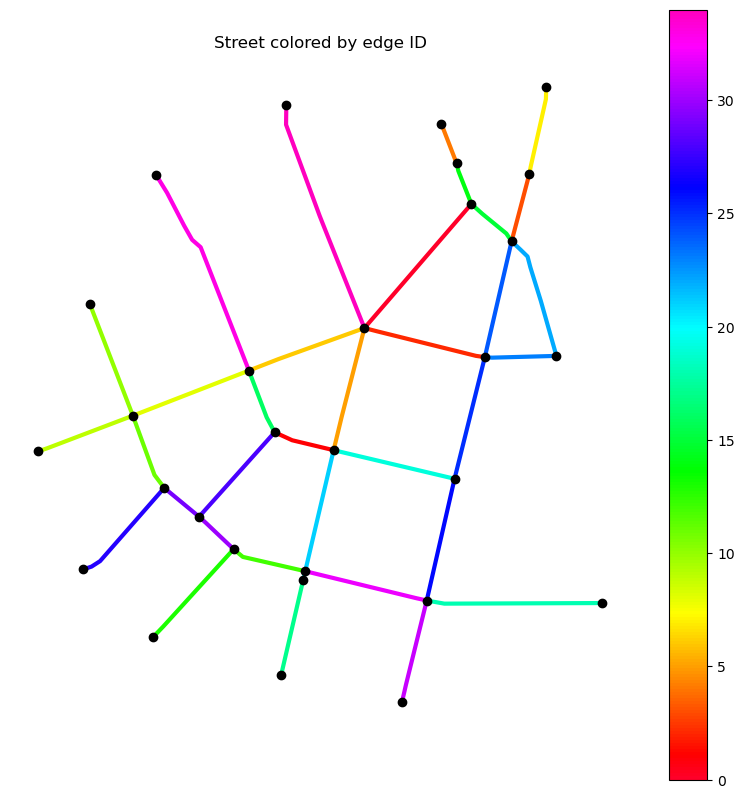

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
lines["index"] = lines.index
lines.plot(
    ax=ax,
    column="index",
    cmap="gist_rainbow",
    lw=3,
    legend=True,
    zorder=0,
)
points.plot(
    ax=ax,
    color="black",
    zorder=1,
)
ax.set_axis_off()
plt.title("Street colored by edge ID")
plt.show()

`COINS` allows to find strokes, that are sets of edges with a natural continuity:

In [4]:
coins = momepy.COINS(lines, angle_threshold=0, flow_mode=False)

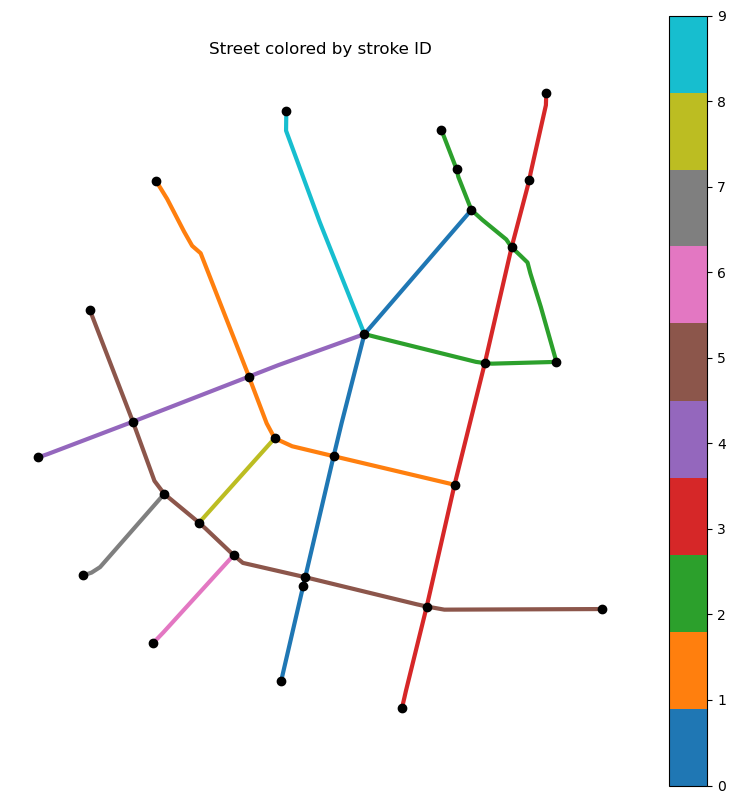

In [5]:
lines.loc[:, "stroke_id"] = coins.stroke_attribute()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lines.plot(
    ax=ax,
    column="stroke_id",
    cmap="tab10",
    lw=3,
    legend=True,
    zorder=0,
)
points.plot(ax=ax, color="black", zorder=1)
ax.set_axis_off()
plt.title("Street colored by stroke ID")
plt.show()

From the strokes, we can also create a stroke graph, where each stroke is a node. If two strokes intersect, we add an edge between the two nodes:

In [6]:
stroke_graph = momepy.coins_to_nx(coins)
stroke_points, stroke_lines = momepy.nx_to_gdf(stroke_graph, points=True, lines=True)

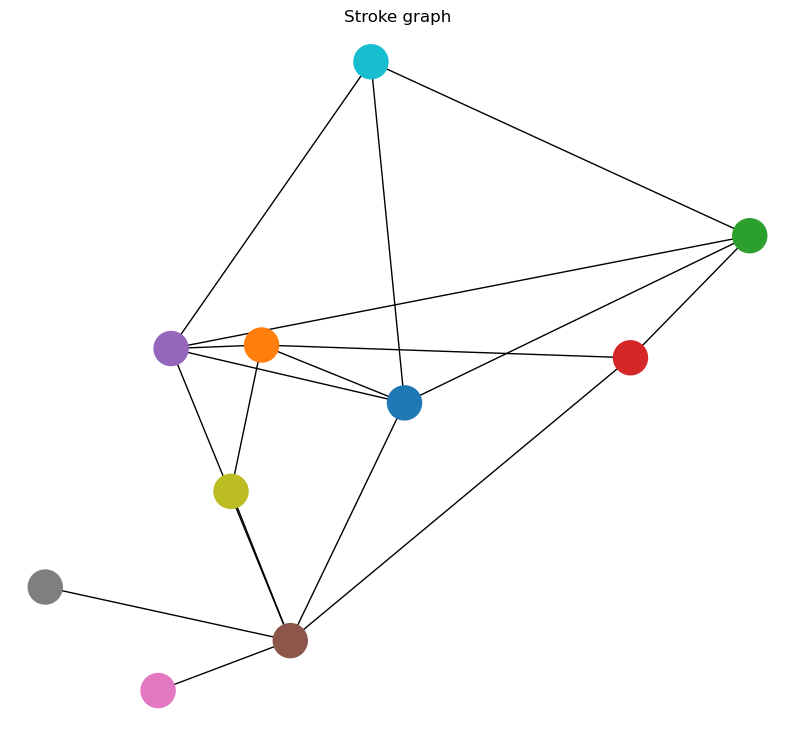

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
stroke_lines.plot(
    ax=ax,
    color="black",
    lw=1,
    legend=True,
    zorder=0,
)
stroke_points.plot(
    ax=ax,
    s=600,
    column="nodeID",
    cmap="tab10",
    zorder=1,
)
ax.set_axis_off()
plt.title("Stroke graph")
plt.show()

You can also see it with an interactive map, with the primal and the dual graph superimposed:

In [8]:
m = lines.explore(
    tiles="cartodb-positron",
    name="Primal graph: edges",
    cmap="tab10",
    column="stroke_id",
)
points.explore(
    m=m,
    name="Primal graph: nodes",
    color="black",
)
stroke_lines.explore(
    m=m,
    color="black",
    name="Stroke graph: edges",
)
stroke_points.explore(
    m=m,
    cmap="tab10",
    column="nodeID",
    marker_kwds={"radius": 10},
    name="Stroke graph: nodes",
)
folium.LayerControl().add_to(m)
m

## Compute stroke graph metric

Using the stroke graph, we can compute several metrics. Some are classical metrics, already implemented in networkx. For instance, the degree shows us how well connected a stroke is to other strokes:

In [9]:
nx.set_node_attributes(stroke_graph, dict(nx.degree(stroke_graph)), "stroke_degree")
stroke_points, stroke_lines = momepy.nx_to_gdf(stroke_graph, points=True, lines=True)

In [10]:
m = lines.explore(
    tiles="cartodb-positron",
    name="Primal graph: edges",
    cmap="tab10",
    column="stroke_id",
)
points.explore(
    m=m,
    name="Primal graph: nodes",
    color="black",
)
stroke_lines.explore(
    m=m,
    color="black",
    name="Stroke graph: edges",
)
stroke_points.explore(
    m=m,
    cmap="viridis",
    column="stroke_degree",
    marker_kwds={"radius": 10},
    name="Stroke graph: nodes",
)
folium.LayerControl().add_to(m)
m

Instead of the maximum length travelled across the street network, the diameter of a stroke graph is the maximum number of "turns" one has to do to travel across the street network. By turns we mean a change of stroke: since strokes are following the natural continuity of the edges, staying on the same stroke is equivalent as going as straight as possible.

In [11]:
nx.diameter(stroke_graph)

3

In bubenec, the diameter of the stroke graph is 3, meaning that we can reach from any place to any other place with making at most 3 "turns".

In a similar way, we can compute centrality metrics. A high betweenness stroke will be one used to travel the simplest paths, meaning the path with the least amount of "turns".

In [12]:
nx.set_node_attributes(
    stroke_graph, dict(nx.betweenness_centrality(stroke_graph)), "stroke_betweenness"
)
stroke_points, stroke_lines = momepy.nx_to_gdf(stroke_graph, points=True, lines=True)

In [13]:
m = lines.explore(
    tiles="cartodb-positron",
    name="Primal graph: edges",
    cmap="tab10",
    column="stroke_id",
)
points.explore(
    m=m,
    name="Primal graph: nodes",
    color="black",
)
stroke_lines.explore(
    m=m,
    color="black",
    name="Stroke graph: edges",
)
stroke_points.explore(
    m=m,
    cmap="viridis",
    column="stroke_betweenness",
    marker_kwds={"radius": 10},
    name="Stroke graph: nodes",
)
folium.LayerControl().add_to(m)
m

We can see that the stroke 4 is a hub of high betweenness. Except for the parallel strokes 1 and 2 and the isolated stroke 9, you can reach any other stroke in a single turn from the stroke 4.

We can also then add the stroke metrics to the edges in the primal graph:

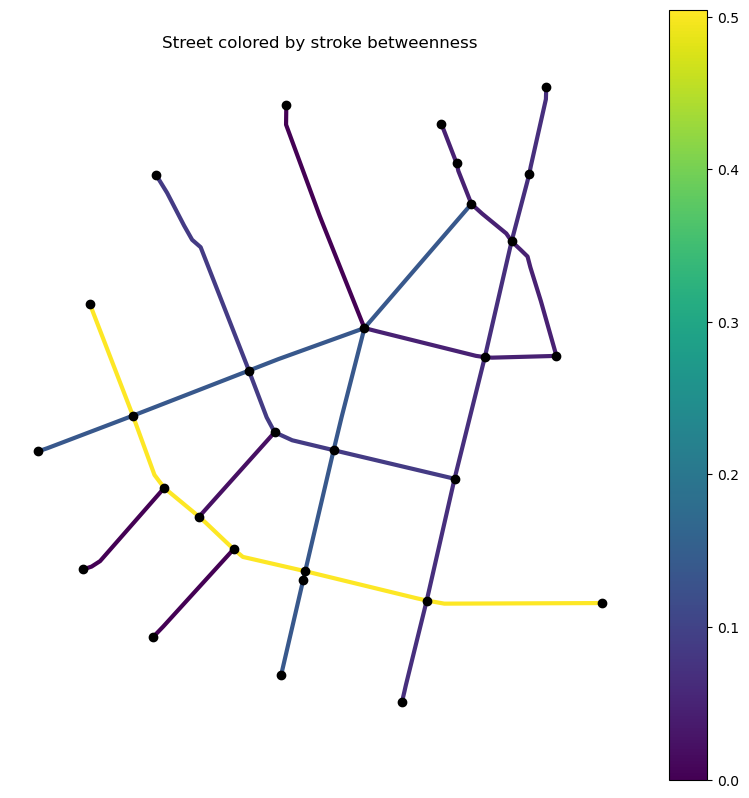

In [14]:
stroke_betweenness_dict = {
    edge_id: stroke_betweenness
    for arr, stroke_betweenness in stroke_points[
        ["edge_indeces", "stroke_betweenness"]
    ].values
    for edge_id in arr
}
lines.loc[:, "stroke_betweenness"] = stroke_betweenness_dict
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lines.plot(
    ax=ax,
    column="stroke_betweenness",
    cmap="viridis",
    lw=3,
    legend=True,
    zorder=0,
)
points.plot(ax=ax, color="black", zorder=1)
ax.set_axis_off()
plt.title("Street colored by stroke betweenness")
plt.show()

On a stroke graph, closeness centrality is equivalent to the integration metric in Space Syntax:

In [15]:
nx.set_node_attributes(
    stroke_graph, dict(nx.closeness_centrality(stroke_graph)), "stroke_closeness"
)
stroke_points, stroke_lines = momepy.nx_to_gdf(stroke_graph, points=True, lines=True)

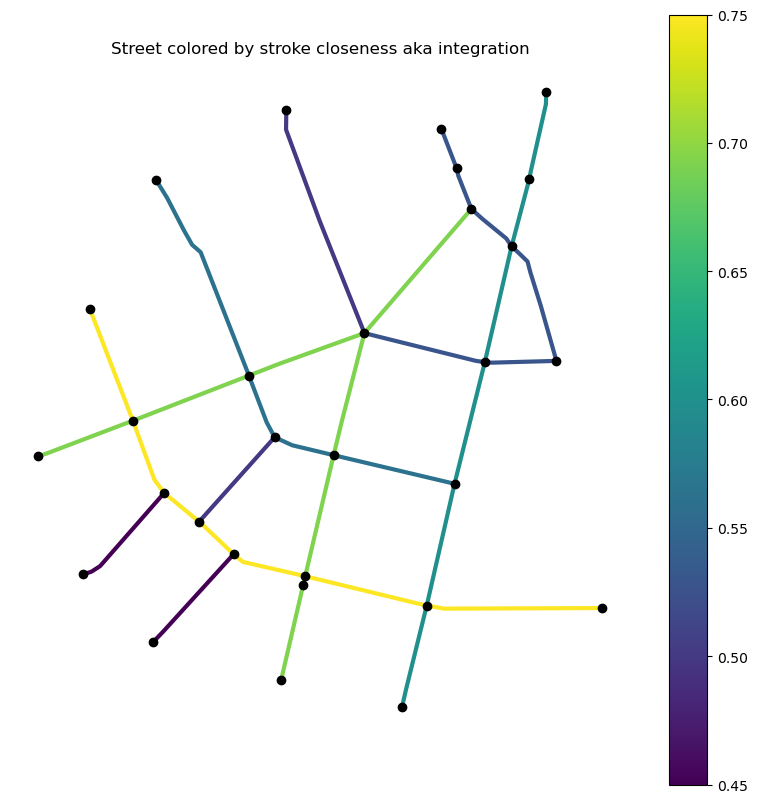

In [16]:
stroke_closeness_dict = {
    edge_id: stroke_closeness
    for arr, stroke_closeness in stroke_points[
        ["edge_indeces", "stroke_closeness"]
    ].values
    for edge_id in arr
}
lines.loc[:, "stroke_closeness"] = stroke_closeness_dict
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lines.plot(
    ax=ax,
    column="stroke_closeness",
    cmap="viridis",
    lw=3,
    legend=True,
    zorder=0,
)
points.plot(ax=ax, color="black", zorder=1)
ax.set_axis_off()
plt.title("Street colored by stroke closeness aka integration")
plt.show()

On top of classical metrics that can all be computed on the stroke graph, we define several new metrics for strokes.

### Stroke access

Access is defined as the difference between the connectivity (the number of arcs intersecting with a stroke) and the degree (the number of strokes intersecting with another stroke). A simple illustration is that for a T-intersection, the degree and the connectivity is the same, while connectivity is higher for an X-intersection.

In [17]:
stroke_graph = momepy.stroke_access(stroke_graph)
stroke_points, stroke_lines = momepy.nx_to_gdf(stroke_graph, points=True, lines=True)

In [18]:
m = lines.explore(
    tiles="cartodb-positron",
    name="Primal graph: edges",
    cmap="tab10",
    column="stroke_id",
)
points.explore(
    m=m,
    name="Primal graph: nodes",
    color="black",
)
stroke_lines.explore(
    m=m,
    color="black",
    name="Stroke graph: edges",
)
stroke_points.explore(
    m=m,
    cmap="viridis",
    column="stroke_access",
    marker_kwds={"radius": 10},
    name="Stroke graph: nodes",
)
folium.LayerControl().add_to(m)
m

### Stroke spacing

Spacing is the average lenght between connections, dividing the total lenght of the stroke by its connectivity.

In [19]:
stroke_graph = momepy.stroke_spacing(stroke_graph)
stroke_points, stroke_lines = momepy.nx_to_gdf(stroke_graph, points=True, lines=True)

In [20]:
m = lines.explore(
    tiles="cartodb-positron",
    name="Primal graph: edges",
    cmap="tab10",
    column="stroke_id",
)
points.explore(
    m=m,
    name="Primal graph: nodes",
    color="black",
)
stroke_lines.explore(
    m=m,
    color="black",
    name="Stroke graph: edges",
)
stroke_points.explore(
    m=m,
    cmap="viridis",
    column="stroke_spacing",
    marker_kwds={"radius": 10},
    name="Stroke graph: nodes",
)
folium.LayerControl().add_to(m)
m

### Stroke orthogonality

Orthogonality is the average sine of the minimum angles between the stroke and its connections. It varies between 0 and 1, from low to right angles.

In [21]:
stroke_graph = momepy.stroke_orthogonality(stroke_graph)
stroke_points, stroke_lines = momepy.nx_to_gdf(stroke_graph, points=True, lines=True)

In [22]:
m = lines.explore(
    tiles="cartodb-positron",
    name="Primal graph: edges",
    cmap="tab10",
    column="stroke_id",
)
points.explore(
    m=m,
    name="Primal graph: nodes",
    color="black",
)
stroke_lines.explore(
    m=m,
    color="black",
    name="Stroke graph: edges",
)
stroke_points.explore(
    m=m,
    cmap="viridis",
    column="stroke_orthogonality",
    marker_kwds={"radius": 10},
    name="Stroke graph: nodes",
)
folium.LayerControl().add_to(m)
m